Generated with ChatGPT and modified, takes in the audio in the dataset folder and sorts it into two sub folders, one with mel spectrograms and one with the audio.

In [1]:
import os
from pathlib import Path
import random
import librosa
from librosa.util import normalize

import numpy as np
import soundfile as sf
import torch

MAX_WAV_VALUE = 32768.0
SEGMENT_SIZE = 8192
SAMPLE_RATE = 22050

def wav_to_mel(y, mel_path=None, sr=22050, n_fft=1024, hop_size=256, win_length=1024, n_mels=80, fmin=0, fmax=8000):


    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_size, win_length=win_length, n_mels=n_mels, fmin=fmin, fmax=fmax, pad_mode="reflect")
    
    # Convert to decibels
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Save the Mel spectrogram as a numpy file
    return mel_spectrogram_db

def process_dataset(dataset_path):
    # Create output directories for Mel spectrograms and wave files
    mel_dir = os.path.join(dataset_path, 'mel_spectrograms')
    wav_dir = os.path.join(dataset_path, 'processed_wavs')
    os.makedirs(mel_dir, exist_ok=True)
    os.makedirs(wav_dir, exist_ok=True)



    audio_paths = list(Path("./data-commonvoice").rglob("*.mp3"))
    print(audio_paths[0])
    # Process each WAV file in the dataset_path
    for path in audio_paths:
        if "mp3" in os.path.basename(path):
            filename = os.path.basename(path)
            wav_path = os.path.join(wav_dir, filename)
            mel_path = os.path.join(mel_dir, filename.replace('.mp3', '.npy'))
            
            # Load the audio file
            y, audio_sr = librosa.load(path)

            # Normalize audio
            y = y / MAX_WAV_VALUE
            y = normalize(y) * 0.95

            # Resample to sr if needed
            if audio_sr != SAMPLE_RATE:
                y = librosa.resample(y, orig_sr=audio_sr, target_sr=SAMPLE_RATE)

            if len(y) >= SEGMENT_SIZE:
                max_audio_start = len(y) - SEGMENT_SIZE
                audio_start = random.randint(0, max_audio_start)
                y = y[audio_start:audio_start+SEGMENT_SIZE]
            else:
                y = torch.nn.functional.pad(y, (0, SEGMENT_SIZE - y.size(1)), 'constant')

            
            # Save truncated audio
            sf.write(wav_path, y, 22050)

            # Transform WAV to Mel spectrogram
            mel = wav_to_mel(y)
            np.save(mel_path, mel)


In [2]:
process_dataset("dataset")

data-commonvoice/audios/2da20b92-6317-4518-904d-a5b8fc338bb8/1a7393cc901b9b3b7cf8dc82adf33d3f5c4f19d5b6eadb9882b81718f8c6ab91.mp3


/tmp/ipykernel_9492/3182172379.py:46: UserWarning: PySoundFile failed. Trying audioread instead.
  y, audio_sr = librosa.load(path)
/home/tugdual/miniconda3/envs/jaxtts/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


EOFError: 

(80, 1243)


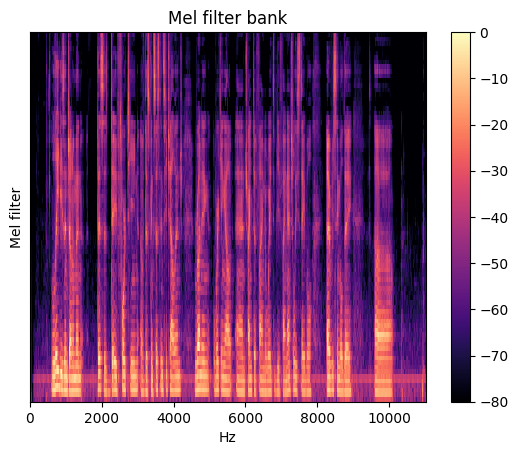

In [14]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

mel_spec = np.load("dataset/mel_spectrograms/rec.npy")
print(mel_spec.shape)
img = librosa.display.specshow(np.array(mel_spec), x_axis='linear', ax=ax)
ax.set(ylabel='Mel filter', title='Mel filter bank')
fig.colorbar(img, ax=ax)
